In [185]:
# Data loading

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

training_set = pd.read_csv('./data/npf_train.csv')
test_set = pd.read_csv('./data/npf_test_hidden.csv')

# Create class2 column
training_set['class2'] = training_set['class4'].apply(lambda x: 'nonevent' if x=='nonevent' else 'event')

del training_set['id']
del training_set['class4'] # still, just binary classification for now
del training_set['date']

del test_set['id']
del test_set['date']

del training_set['partlybad'] # useless field, it is always False
del test_set['partlybad']

# Binary classification atm
X_train = training_set[training_set.columns.difference(['class2'])]
y_train = training_set['class2'].apply(lambda x: 0 if x=='nonevent' else 1) # 0 = nonevent, 1 = event

X_test = test_set[test_set.columns.difference(['class4'])]

In [29]:
# Baseline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
print('BASELINE')
print('Accuracy on training set:', clf.fit(X_train, y_train).score(X_train, y_train))
print('CV accuracy:', cross_val_score(clf, X_train, y_train, cv=5).mean())


BASELINE
Accuracy on training set: 1.0
CV accuracy: 0.8517200191113234


# Data resampling

In [152]:
GAUSSIAN_N = 8

new_train = training_set.rename(columns=lambda x: x.replace('.', ''))

mean_cols = new_train[[c for c in new_train if 'mean' in c]].rename(columns= lambda x: x.replace('mean', ''))
std_cols = new_train[[c for c in new_train if 'std' in c]].rename(columns= lambda x: x.replace('std', ''))

new_DATA = pd.DataFrame()

# spaghetti but was going crazy
for row in range(mean_cols.shape[0]):
    t = pd.DataFrame()
    for i in range(mean_cols.shape[1]):
        norm = np.random.normal(mean_cols.iloc[row][i], std_cols.iloc[row][i], GAUSSIAN_N)
        t = pd.concat([t, pd.DataFrame(norm)], axis=1)
    new_DATA = pd.concat([new_DATA, t])

new_train = new_DATA
new_train.columns = mean_cols.columns

In [153]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

new_X_train = new_train
new_y_train = training_set['class2'].apply(lambda x: 0 if x=='nonevent' else 1) # 0 = nonevent, 1 = event
new_y_train = new_y_train.loc[new_y_train.index.repeat(GAUSSIAN_N)]

clf = RandomForestClassifier()
print('WITH SAMPLED DATA')
print('Accuracy on training set:', clf.fit(X_train, y_train).score(X_train, y_train))
print('CV accuracy:', cross_val_score(clf, X_train, y_train, cv=5).mean())

BASELINE
Accuracy on training set: 1.0
CV accuracy: 0.8626134734830387


# Feature selection

/home/enrico/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


<AxesSubplot:>

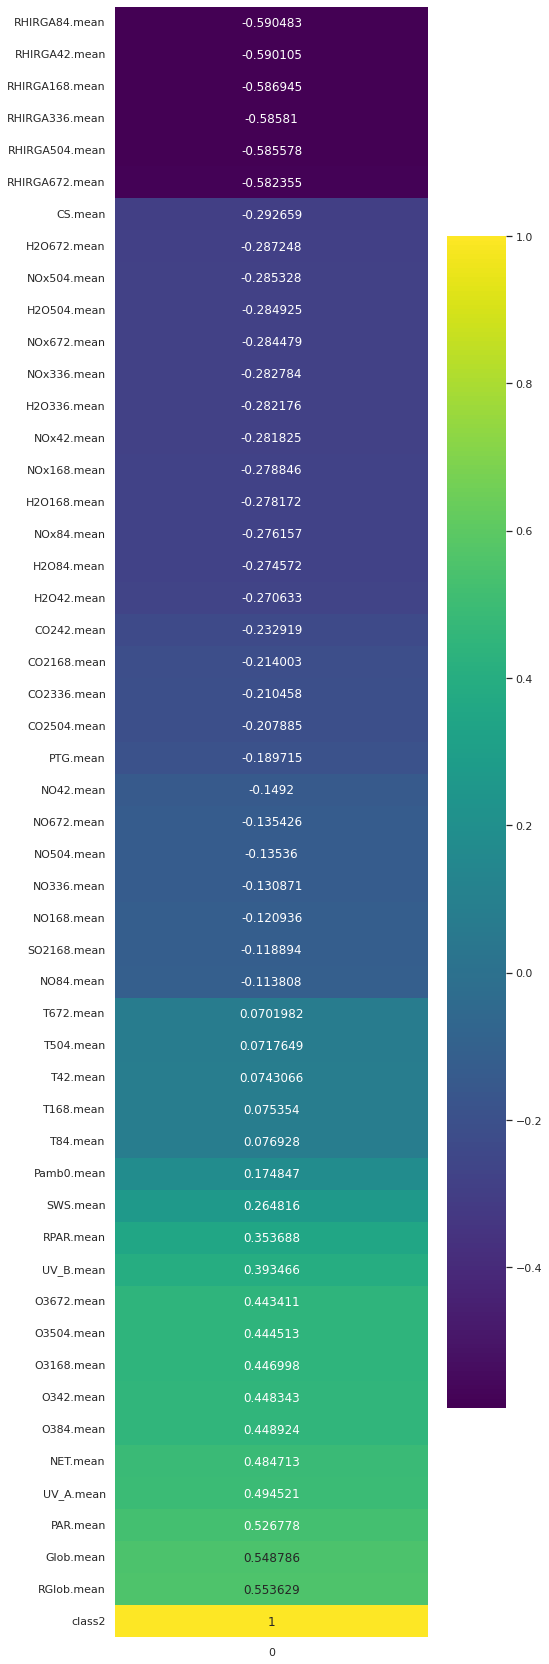

In [184]:
cor_cols = training_set[[c for c in training_set if 'mean' in c]]
cor_cols = pd.concat([cor_cols, y_train], axis=1)
cor_cols = cor_cols.corr()['class2'].sort_values()
sns.set(rc={'figure.figsize':(7,30)})
sns.heatmap(cor_cols[:, np.newaxis], annot=True, fmt="g", cmap='viridis', yticklabels=cor_cols.index)

In [188]:
# removing features with low variance
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
red_X_train = sel.fit_transform(X_train)

print('WITH FEATURE REDUCTION')
print('Accuracy on training set:', clf.fit(red_X_train, y_train).score(red_X_train, y_train))
print('CV accuracy:', cross_val_score(clf, red_X_train, y_train, cv=5).mean())

WITH FEATURE REDUCTION
Accuracy on training set: 1.0
CV accuracy: 0.8451027233635928


# Both?

In [192]:
GAUSSIAN_N = 8

new_train = training_set.rename(columns=lambda x: x.replace('.', ''))

mean_cols = new_train[[c for c in new_train if 'mean' in c]].rename(columns= lambda x: x.replace('mean', ''))
std_cols = new_train[[c for c in new_train if 'std' in c]].rename(columns= lambda x: x.replace('std', ''))

new_DATA = pd.DataFrame()

# spaghetti but was going crazy
for row in range(mean_cols.shape[0]):
    t = pd.DataFrame()
    for i in range(mean_cols.shape[1]):
        norm = np.random.normal(mean_cols.iloc[row][i], std_cols.iloc[row][i], GAUSSIAN_N)
        t = pd.concat([t, pd.DataFrame(norm)], axis=1)
    new_DATA = pd.concat([new_DATA, t])

new_train = new_DATA
new_train.columns = mean_cols.columns

new_X_train = new_train
new_y_train = training_set['class2'].apply(lambda x: 0 if x=='nonevent' else 1) # 0 = nonevent, 1 = event
new_y_train = new_y_train.loc[new_y_train.index.repeat(GAUSSIAN_N)]


from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
red_X_train = sel.fit_transform(new_X_train)


print('WITH BOTH')
print('Accuracy on training set:', clf.fit(red_X_train, new_y_train).score(red_X_train, new_y_train))
print('CV accuracy:', cross_val_score(clf, red_X_train, new_y_train, cv=5).mean())

WITH BOTH
Accuracy on training set: 1.0
CV accuracy: 0.835972386852444
